In [3]:
import shap
from datasets import load_dataset
from src.utils import MODEL_NAME_TO_DESC_DICT, format_text_pred, prepare_text
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForSequenceClassification, pipeline, AutoTokenizer
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm import tqdm

import lightgbm as lgb


/home/james/CodingProjects/TextNTabularExplanations/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_df = load_dataset(
    "james-burton/imdb_genre_prediction2", split="train"
).to_pandas()


Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [5]:
t = load_dataset("james-burton/imdb_genre_prediction2", split="test[:10]")
t.to_pandas()[
    [
        "Year",
        "Runtime (Minutes)",
        "Rating",
        "Votes",
        "Revenue (Millions)",
        "Metascore",
        "Rank",
    ]
].values


Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


array([[2.00900000e+03, 9.50000000e+01, 7.70000000e+00, 3.98972000e+05,
        3.23900000e+01, 7.60000000e+01, 5.08000000e+02],
       [2.01600000e+03, 1.08000000e+02, 5.70000000e+00, 2.47610000e+04,
        5.40000000e-01, 2.20000000e+01, 5.38000000e+02],
       [2.01600000e+03, 1.08000000e+02, 6.30000000e+00, 1.06600000e+03,
        8.32676836e+01, 6.40000000e+01, 8.49000000e+02],
       [2.01600000e+03, 1.23000000e+02, 7.10000000e+00, 1.71410000e+04,
        7.70000000e+00, 7.90000000e+01, 5.52000000e+02],
       [2.01500000e+03, 1.13000000e+02, 6.70000000e+00, 4.16420000e+04,
        8.32676836e+01, 7.10000000e+01, 4.80000000e+02],
       [2.01400000e+03, 9.90000000e+01, 8.10000000e+00, 5.30881000e+05,
        5.90700000e+01, 8.80000000e+01, 2.39000000e+02],
       [2.01600000e+03, 1.01000000e+02, 7.90000000e+00, 5.23310000e+04,
        5.20000000e+00, 8.10000000e+01, 4.48000000e+02],
       [2.00800000e+03, 9.30000000e+01, 7.80000000e+00, 5.02961000e+05,
        1.45000000e+02, 5

In [6]:
t1 = t.to_pandas()[
    [
        "Year",
        "Runtime (Minutes)",
        "Rating",
        "Votes",
        "Revenue (Millions)",
        "Metascore",
        "Rank",
    ]
].values
# append t['Description'] to t1
t2 = np.hstack((t1, np.expand_dims(np.array(t["Description"]), axis=1)))


In [7]:
t1.shape


(10, 7)

In [8]:
t2[0, -1]

"An offbeat romantic comedy about a woman who doesn't believe true love exists, and the young man who falls for her."

In [9]:
np.array(t["Description"]).shape

(10,)

In [10]:
kmeans = shap.kmeans(t1, 1).data
kmeans


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([[2.01400e+03, 1.01000e+02, 7.10000e+00, 2.13764e+05, 5.90700e+01,
        6.40000e+01, 5.38000e+02]])

In [11]:
shap.kmeans(t1, 5).weights

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([0.4, 0.1, 0.1, 0.2, 0.2])

In [12]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer(t2[0,-1], return_tensors="pt")

masker = shap.maskers.Text(tokenizer)


In [13]:
masker.shape(t2[0, -1])[1]

28

In [14]:
m00 = np.zeros(masker.shape(t2[0, -1])[1])

In [15]:
m00


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
t2[0, -1]

"An offbeat romantic comedy about a woman who doesn't believe true love exists, and the young man who falls for her."

In [17]:
masker(m00, t2[0, -1])

(array(['[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]'],
       dtype='<U181'),)

In [18]:
def custom_masker(mask, x):
    tab_mask = mask[:7]  # 7 is the number of tabular features
    text_mask = mask[7:]
    masker(text_mask, x)
    return masker.shape(x)[-1]

In [19]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_masker = shap.maskers.Text(tokenizer)


def custom_masker(mask, x, M_tab):
    tab_mask = mask[:M_tab]
    text_mask = mask[M_tab:]
    masked_tab = x[:M_tab] * tab_mask
    masked_text = text_masker(mask[M_tab:], x[M_tab])
    return np.hstack([masked_tab.astype("O"), masked_text[0]])


reference = [1.6, -0.6, "hi there"]
mask = np.array([1.0, 1.0, 1.0, 0.0, 1.0, 1.0])

custom_masker(mask, reference, 2)


array([1.6, -0.6, '[MASK]there'], dtype=object)

In [20]:
masker.token_segments(reference[-1])


(['', 'hi ', 'there', ''], [101, 7632, 2045, 102])

In [21]:
m00 = np.zeros(masker.shape("offbeat romantic comedy")[1])
m00

array([0., 0., 0., 0., 0., 0.])

In [22]:
mask = np.array([1, 1, 0, 1])
text_masker(np.array([1, 1, 0, 1]), "hi there")

(array(['hi [MASK]'], dtype='<U9'),)

In [23]:
tab_cols = [
    "Year",
    "Runtime (Minutes)",
    "Rating",
    "Votes",
    "Revenue (Millions)",
    "Metascore",
    "Rank",
]
np.concatenate(
    [np.zeros(len(tab_cols)), [tokenizer.mask_token]
     * masker.shape(t2[0, -1])[1]]
)

array(['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]'], dtype='<U32')

In [24]:
masker.shape(t2[0, -1])[1]

28

In [25]:
tokenizer.mask_token


'[MASK]'

(['', 'romantic ', 'comedy', ''], [101, 6298, 4038, 102])


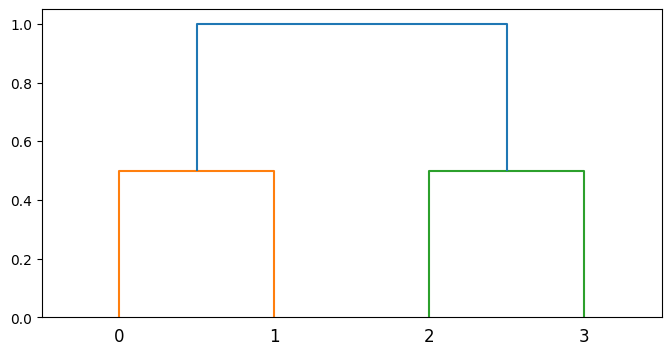

[[0.  1.  0.5 2. ]
 [2.  3.  0.5 2. ]
 [4.  5.  1.  4. ]]


In [26]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

sample_text = "romantic comedy"
print(masker.token_segments(sample_text))
Z = masker.clustering(sample_text)
fig = plt.figure(figsize=(8, 4))
dn = dendrogram(Z)
plt.show()
print(Z)


(['', 'organic ', 'romantic ', 'comedy', ''], [101, 7554, 6298, 4038, 102])


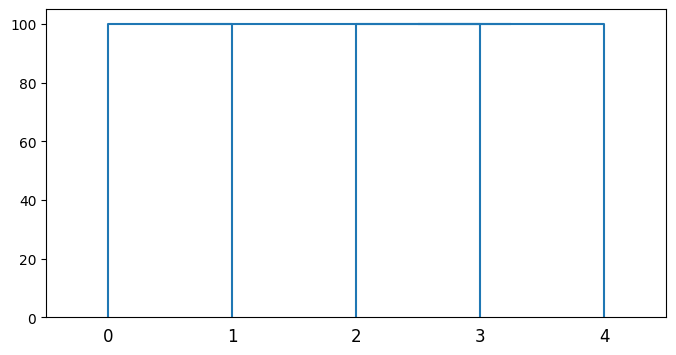

[[0.  1.  0.4 2. ]
 [2.  3.  0.4 2. ]
 [6.  4.  0.6 3. ]
 [5.  7.  1.  5. ]]


In [27]:
sample_text = "organic romantic comedy"
print(masker.token_segments(sample_text))
Z = masker.clustering(sample_text)
fig = plt.figure(figsize=(8, 4))
dn = dendrogram(
    np.array(
        [
            [0.0, 1.0, 100.0, 1.0],
            [2.0, 3.0, 100.0, 2.0],
            [6.0, 4.0, 100.0, 3.0],
            [5.0, 7.0, 100.0, 4.0],
        ]
    )
)
plt.show()
print(Z)


In [28]:
train_df = load_dataset(
    "james-burton/imdb_genre_prediction2", split="train[:10]"
).to_pandas()


Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [29]:
import scipy as sp


In [30]:
D = sp.spatial.distance.pdist(
    train_df[["Rating", "Runtime (Minutes)", "Votes"]].T, metric="correlation"
)
C = sp.cluster.hierarchy.complete(D)
# cluster_matrix = shap.partition_tree(X)
C


array([[0.        , 2.        , 0.32772815, 2.        ],
       [1.        , 3.        , 1.03498895, 3.        ]])

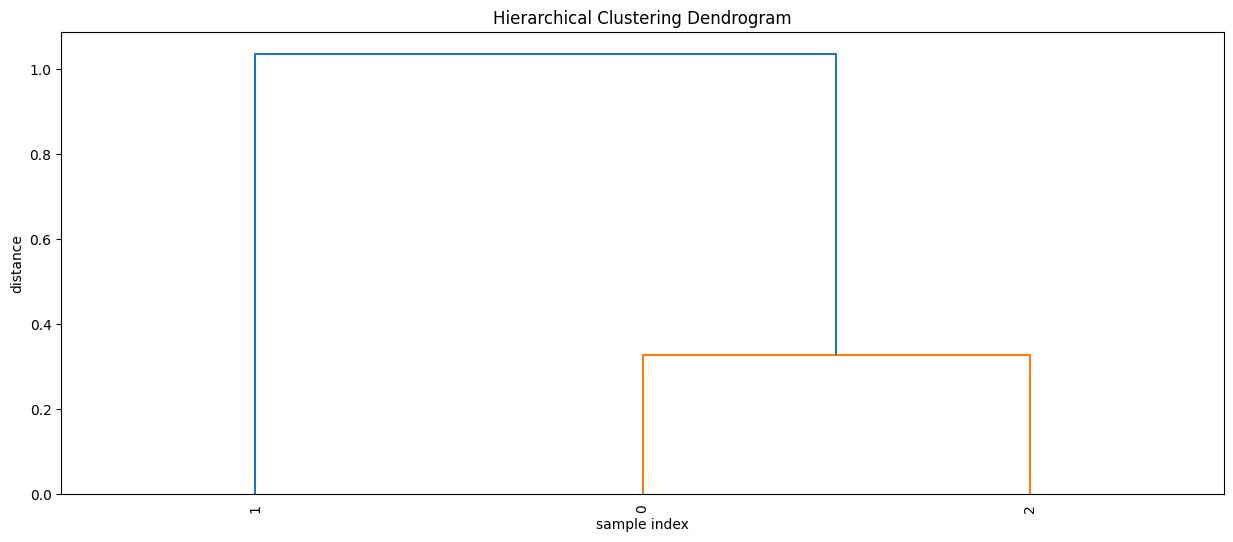

In [31]:
plt.figure(figsize=(15, 6))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("sample index")
plt.ylabel("distance")
sp.cluster.hierarchy.dendrogram(
    C,
    leaf_rotation=90.0,  # rotates the x axis labels
    leaf_font_size=10.0,  # font size for the x axis labels
    # labels=['Rating', 'Runtime (Minutes)', 'Votes']
)
plt.show()


In [32]:
np.concatenate([Z, C + [6, 6, 0, 0], [[10.0, 11.0, 1.5, 7.0]]])

array([[ 0.        ,  1.        ,  0.4       ,  2.        ],
       [ 2.        ,  3.        ,  0.4       ,  2.        ],
       [ 6.        ,  4.        ,  0.6       ,  3.        ],
       [ 5.        ,  7.        ,  1.        ,  5.        ],
       [ 6.        ,  8.        ,  0.32772815,  2.        ],
       [ 7.        ,  9.        ,  1.03498895,  3.        ],
       [10.        , 11.        ,  1.5       ,  7.        ]])

In [33]:
C


array([[0.        , 2.        , 0.32772815, 2.        ],
       [1.        , 3.        , 1.03498895, 3.        ]])

In [34]:
n_tab_leaves = 3
text_groups = 4
n_text_leaves = 5
np.where(
    C[:, :2] >= n_tab_leaves,
    C[:, :2] + n_text_leaves + text_groups,
    C[:, :2] + n_text_leaves,
)


array([[ 5.,  7.],
       [ 6., 12.]])

In [35]:
C[:, :2] >= n_tab_leaves

array([[False, False],
       [False,  True]])

In [36]:
Z_leaves = len(np.hstack(Z[:, :2]))
C_leaves = len(np.hstack(C[:, :2]))
total_leaves = float(Z_leaves + C_leaves)

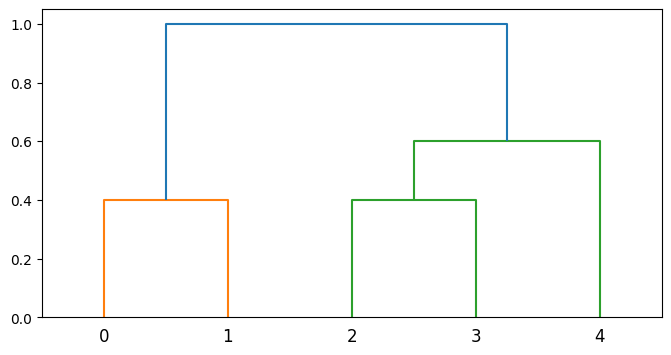

In [37]:
Z
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
# , labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
dn = dendrogram(Z)
plt.show()

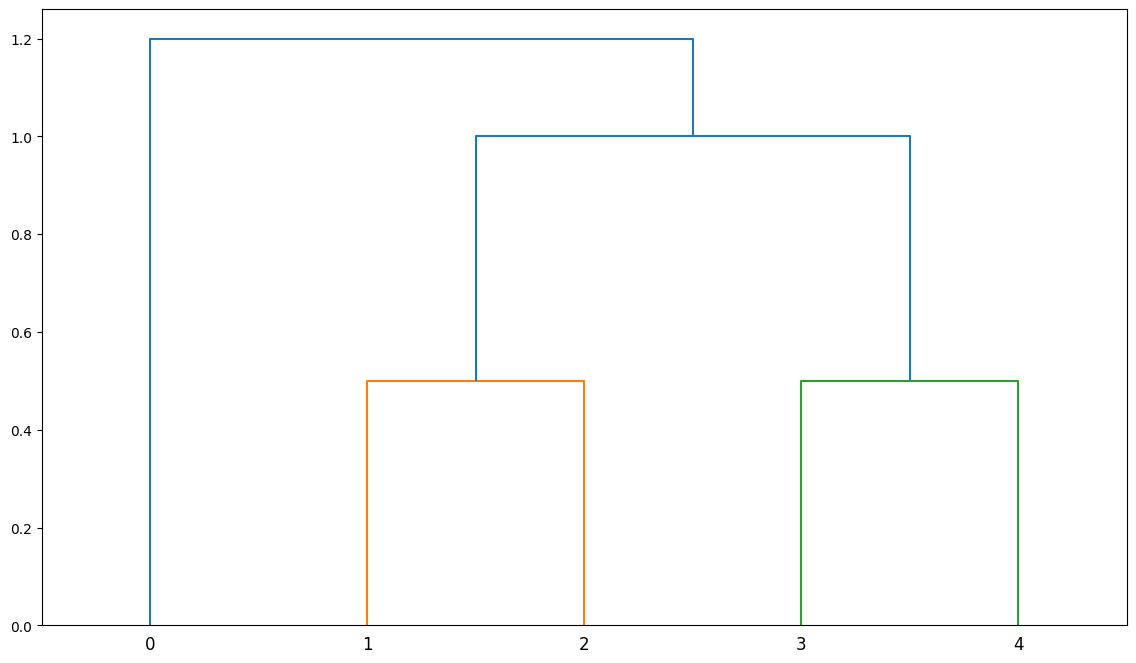

In [44]:
# Z_join = np.array([
#     [ 1.        ,  2.        ,  0.33333333,  2.        ],
#        [ 3.        ,  4.        ,  0.33333333,  2.        ],
#        [ 0.        ,  9.        ,  0.5       ,  3.        ],
#        [10.        ,  5.        ,  0.5       ,  3.        ],
#        [11.        , 12.        ,  1.        ,  6.        ],
#        [ 6.        ,  7.        ,  0.32772815,  2.        ],
#        [ 8.        , 14.        ,  0.69322193,  3.        ],
#        [13.        , 15.        ,  1.5       ,  9.        ]])
Z_join = np.array(
    [
        [0.0, 1.0, 0.32772815, 2.0],
        [2.0, 9.0, 0.69322193, 3.0],
        [4.0, 5.0, 0.33333333, 2.0],
        [6.0, 7.0, 0.33333333, 2.0],
        [3.0, 11.0, 0.5, 3.0],
        [12.0, 8.0, 0.5, 3.0],
        [13.0, 14.0, 1.0, 6.0],
        [10.0, 15.0, 1.5, 9.0],
    ]
)

Z_join = np.array([[1., 2., 0.5, 0.],
                   [3., 4., 0.5, 0.],
                   [5., 6., 1.0, 0.],
                   [0., 7., 1.2, 0.],])
fig = plt.figure(figsize=(14, 8))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
# , labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
dn = dendrogram(
    Z_join,
    #             labels=[
    # "Year",
    # "Runtime (Minutes)",
    # "Rating",
    # "Votes",
    # "Revenue (Millions)",
    # "Metascore",
    # "Rank",
    # " ",
    # "An",
    # "off",
    # "beat",
    # "romantic",
    # "comedy",
    # "about",
    # "a",
    # "woman",
    # "who",
    # "doesn",
    # "'",
    # "t",
    # "believe",
    # "true",
    # "love",
    # "exists",
    # ",",
    # "and",
    # "the",
    # "young",
    # "man",
    # "who",
    # "falls",
    # "for",
    # "her",
    # ".",
    # '']
)
plt.show()

In [37]:
y = Z.copy()
y  # (Z[:,:2]>=6)*3

array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])

In [38]:
y[:, :2] += (Z[:, :2] >= 6) * 3


In [39]:
Z


array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])

In [40]:
C


array([[0.        , 2.        , 0.32772815, 2.        ],
       [1.        , 3.        , 1.03498895, 3.        ]])

In [41]:
np.concatenate([Z, C])

array([[0.        , 1.        , 0.4       , 2.        ],
       [2.        , 3.        , 0.4       , 2.        ],
       [6.        , 4.        , 0.6       , 3.        ],
       [5.        , 7.        , 1.        , 5.        ],
       [0.        , 2.        , 0.32772815, 2.        ],
       [1.        , 3.        , 1.03498895, 3.        ]])

In [42]:
len(np.hstack(Z[:, :2]))

8

In [43]:
def combine_dendrograms(tab_pt, text_pt, n_tab_leaves, n_text_leaves):
    """
    Dendrograms creation works by having each one of the base leaves as a number, then
    labelling each one of the new created nodes a number following the last leaf number.

    eg for array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])

    In this case we know previously leaves are [0,1,2,3,4] (I don't think there is an easy
    way to calculate this from the dendrogram itself). Therefore the pairing of (0,1) from
    row 0 is labelled as 5, (2,3) from row 1 is labelled as 6, (6,4) from row 2 is labelled as 7
    and (5,7) from row 3 is labelled as 8.
    """
    n_text_groups = len(text_pt)
    n_tab_groups = len(tab_pt)

    # References to non-leaf nodes need to be shifted by the number of new leaves
    Z_join = np.zeros([n_tab_groups + n_text_groups + 1, 4])
    Z_join[:n_text_groups, :2] = np.where(
        text_pt[:, :2] >= n_text_leaves, text_pt[:, :2] +
        n_tab_leaves, text_pt[:, :2]
    )
    Z_join[n_text_groups:-1, :2] = np.where(
        tab_pt[:, :2] >= n_tab_leaves,
        tab_pt[:, :2] + n_text_leaves + n_text_groups,
        tab_pt[:, :2] + n_text_leaves,
    )
    # 3rd and 4th columns are left unchanged
    Z_join[:n_text_groups, 2:] = text_pt[:, 2:]
    Z_join[n_text_groups:-1, 2:] = tab_pt[:, 2:]

    # Z_text[:,:2] += (Z_text[:,:2]>=n_text_leaves)*n_tab_leaves
    # Z_tab[:,:2] = np.where(Z_tab[:,:2]>=n_tab_leaves,Z_tab[:,:2]+n_text_leaves+ n_text_groups,
    #                        Z_tab[:,:2]+n_text_leaves)

    # Create top join, joining the text and tab dendrograms together
    top_text_node = n_text_leaves + n_tab_leaves + n_text_groups + -1
    top_tab_node = top_text_node + n_tab_groups
    # Set similarity of top node to 1.5
    Z_join[-1, :] = np.array(
        [top_text_node, top_tab_node, 1.5, n_tab_leaves + n_text_leaves]
    )

    return Z_join


Z_combined = combine_dendrograms(C, Z, 3, 5)
Z_combined

array([[ 0.        ,  1.        ,  0.4       ,  2.        ],
       [ 2.        ,  3.        ,  0.4       ,  2.        ],
       [ 9.        ,  4.        ,  0.6       ,  3.        ],
       [ 8.        , 10.        ,  1.        ,  5.        ],
       [ 5.        ,  7.        ,  0.32772815,  2.        ],
       [ 6.        , 12.        ,  1.03498895,  3.        ],
       [11.        , 13.        ,  1.5       ,  8.        ]])

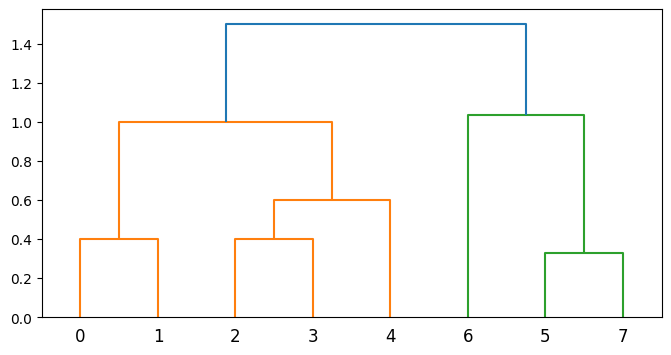

In [44]:
C
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
# , labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
dn = dendrogram(Z_combined)
plt.show()

In [45]:
Z_comb2

NameError: name 'Z_comb2' is not defined

In [ ]:
np.sort(Z_comb2, axis=0)


array([[ 0.        ,  1.        ,  0.4       ,  2.        ],
       [ 2.        ,  3.        ,  0.4       ,  2.        ],
       [ 5.        ,  4.        ,  0.49212894,  2.        ],
       [ 6.        ,  7.        ,  0.6       ,  3.        ],
       [ 8.        , 10.        ,  0.62301468,  3.        ],
       [ 9.        , 11.        ,  1.        ,  5.        ],
       [12.        , 13.        ,  1.5       , 12.        ]])

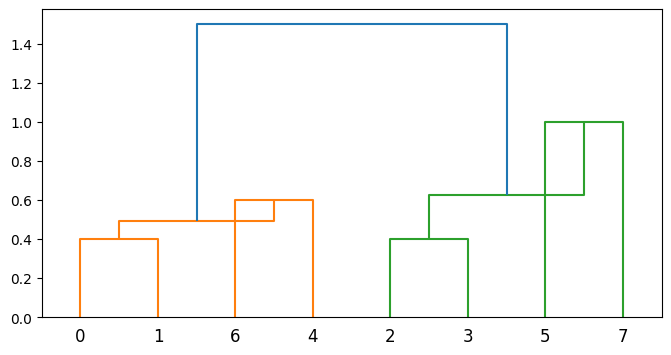

In [ ]:
Z_comb2 = np.concatenate(
    [
        Z,
        C + [Z_leaves, Z_leaves, 0, 0],
        [[total_leaves, total_leaves + 1, 1.5, total_leaves]],
    ]
)
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
# , labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
dn = dendrogram(Z_comb2)
plt.show()


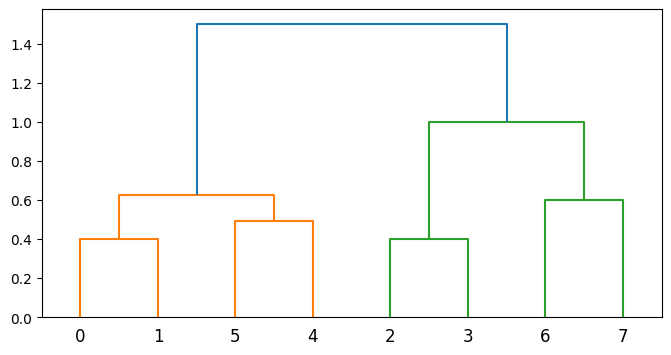

In [ ]:
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
# , labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
dn = dendrogram(np.sort(Z_comb2, axis=0))
plt.show()

In [ ]:
len(np.hstack(Z[:, :2]))

4

In [ ]:
Z


array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])

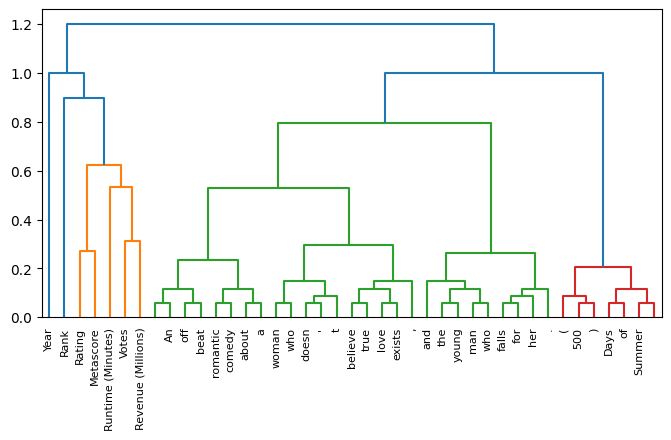

In [46]:
Z3 = np.array(
    [
        [2.00000000e00, 5.00000000e00, 2.70342704e-01, 2.00000000e00],
        [3.00000000e00, 4.00000000e00, 3.13240150e-01, 2.00000000e00],
        [1.00000000e00, 4.20000000e01, 5.33938403e-01, 3.00000000e00],
        [4.10000000e01, 4.30000000e01, 6.21830782e-01, 5.00000000e00],
        [6.00000000e00, 4.40000000e01, 8.96265261e-01, 6.00000000e00],
        [0.00000000e00, 4.50000000e01, 1.00000000e00, 7.00000000e00],
        [9.00000000e00, 1.00000000e01, 5.88235294e-02, 2.00000000e00],
        [1.70000000e01, 1.80000000e01, 5.88235294e-02, 2.00000000e00],
        [4.80000000e01, 1.90000000e01, 8.82352941e-02, 3.00000000e00],
        [7.00000000e00, 8.00000000e00, 5.88235294e-02, 2.00000000e00],
        [1.10000000e01, 1.20000000e01, 5.88235294e-02, 2.00000000e00],
        [1.30000000e01, 1.40000000e01, 5.88235294e-02, 2.00000000e00],
        [1.50000000e01, 1.60000000e01, 5.88235294e-02, 2.00000000e00],
        [2.00000000e01, 2.10000000e01, 5.88235294e-02, 2.00000000e00],
        [2.20000000e01, 2.30000000e01, 5.88235294e-02, 2.00000000e00],
        [2.60000000e01, 2.70000000e01, 5.88235294e-02, 2.00000000e00],
        [2.80000000e01, 2.90000000e01, 5.88235294e-02, 2.00000000e00],
        [3.00000000e01, 3.10000000e01, 5.88235294e-02, 2.00000000e00],
        [3.50000000e01, 3.60000000e01, 5.88235294e-02, 2.00000000e00],
        [3.70000000e01, 3.80000000e01, 5.88235294e-02, 2.00000000e00],
        [3.90000000e01, 4.00000000e01, 5.88235294e-02, 2.00000000e00],
        [5.80000000e01, 3.20000000e01, 8.82352941e-02, 3.00000000e00],
        [5.00000000e01, 4.70000000e01, 1.17647059e-01, 4.00000000e00],
        [5.10000000e01, 5.20000000e01, 1.17647059e-01, 4.00000000e00],
        [5.40000000e01, 5.50000000e01, 1.17647059e-01, 4.00000000e00],
        [5.60000000e01, 5.70000000e01, 1.17647059e-01, 4.00000000e00],
        [6.00000000e01, 6.10000000e01, 1.17647059e-01, 4.00000000e00],
        [5.30000000e01, 4.90000000e01, 1.47058824e-01, 5.00000000e00],
        [6.20000000e01, 3.30000000e01, 1.17647059e-01, 4.00000000e00],
        [3.40000000e01, 5.90000000e01, 8.82352941e-02, 3.00000000e00],
        [6.50000000e01, 2.40000000e01, 1.47058824e-01, 5.00000000e00],
        [2.50000000e01, 6.60000000e01, 1.47058824e-01, 5.00000000e00],
        [6.30000000e01, 6.40000000e01, 2.35294118e-01, 8.00000000e00],
        [7.20000000e01, 6.90000000e01, 2.64705882e-01, 9.00000000e00],
        [7.00000000e01, 6.70000000e01, 2.05882353e-01, 7.00000000e00],
        [6.80000000e01, 7.10000000e01, 2.94117647e-01, 1.00000000e01],
        [7.30000000e01, 7.60000000e01, 5.29411765e-01, 1.80000000e01],
        [7.70000000e01, 7.40000000e01, 7.94117647e-01, 2.70000000e01],
        [7.80000000e01, 7.50000000e01, 1.00000000e00, 3.40000000e01],
        [4.60000000e01, 7.90000000e01, 1.20000000e00, 4.10000000e01],
    ]
)
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
# , labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
dn = dendrogram(
    Z3,
    labels=[
        "Year",
        "Runtime (Minutes)",
        "Rating",
        "Votes",
        "Revenue (Millions)",
        "Metascore",
        "Rank",
        "",
        "An",
        "off",
        "beat",
        "romantic",
        "comedy",
        "about",
        "a",
        "woman",
        "who",
        "doesn",
        "'",
        "t",
        "believe",
        "true",
        "love",
        "exists",
        ",",
        "and",
        "the",
        "young",
        "man",
        "who",
        "falls",
        "for",
        "her",
        ".",
        "(",
        "500",
        ")",
        "Days",
        "of",
        "Summer",
        "",
    ],
)
plt.show()

# sp.cluster.hierarchy.dendrogram(
#     Z,
#     #leaf_rotation=90.,  # rotates the x axis labels
#     #leaf_font_size=10.,  # font size for the x axis labels
#     #labels=['Rating', 'Runtime (Minutes)', 'Votes']
# )


In [76]:
0: ['Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore', 'Rank', '', 'An', 'off', 'beat', 'romantic', 'comedy', 'about', ...]


array([[0. , 1. , 0.5, 2. ],
       [2. , 3. , 0.5, 2. ],
       [4. , 5. , 1. , 4. ]])

In [14]:
[0] + [1, 2, 3]


[0, 1, 2, 3]

In [65]:
cluster_matrix


array([[1.        , 2.        , 0.49212894, 2.        ],
       [0.        , 3.        , 0.62301468, 3.        ]])

In [ ]:
masker.shape(sample_text)


(1, 11)

In [ ]:
# text_model = torch.compile(text_model)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_pipeline = pipeline(
    "text-classification",
    model="james-burton/imdb_genre_9",
    tokenizer=tokenizer,
    device="cuda:0",
)


In [ ]:
test_df = load_dataset("james-burton/imdb_genre_prediction2", split="test")
tab_cols = [
    "Year",
    "Runtime (Minutes)",
    "Rating",
    "Votes",
    "Revenue (Millions)",
    "Metascore",
    "Rank",
]
text_col = ["Description"]

test_df_text = prepare_text(test_df, "text_col_only")
test_df_tab = test_df.to_pandas()[tab_cols]

train_df = load_dataset(
    "james-burton/imdb_genre_prediction2", split="train"
).to_pandas()
train_df_tab = train_df[tab_cols]
y_train = train_df["Genre_is_Drama"]

tab_model = lgb.LGBMClassifier(random_state=42)
# tab_model = XGBClassifier(random_state=42)
tab_model.fit(train_df_tab, y_train)


def tab_pred_fn(examples):
    preds = tab_model.predict_proba(examples)
    return preds


Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [ ]:
class Model:
    def __init__(self, text_to_pred_dict=None):
        self.text_to_pred_dict = text_to_pred_dict
        self.text_pred_len = 0

    def predict_both(self, examples, text_weight=0.5, load_from_cache=True):
        tab_examples = examples[:, :-1]
        tab_preds = tab_model.predict_proba(tab_examples)
        text_examples = examples[:, -1]

        desc_dict = {}
        for i, desc in tqdm(enumerate(text_examples)):
            if desc not in desc_dict:
                desc_dict[desc] = [i]
            else:
                desc_dict[desc].append(i)

        if load_from_cache:
            text_preds = np.array(
                [self.text_to_pred_dict[desc] for desc in desc_dict.keys()]
            )

        else:
            text_preds = text_pipeline(list(desc_dict.keys()))
            text_preds = np.array([format_text_pred(pred)
                                  for pred in text_preds])

        expanded_text_preds = np.zeros((len(text_examples), 2))
        for i, (desc, idxs) in enumerate(desc_dict.items()):
            expanded_text_preds[idxs] = text_preds[i]

        # Combine the predictions, multiplying the text and predictions by 0.5
        preds = text_weight * expanded_text_preds + \
            (1 - text_weight) * tab_preds
        return preds

In [ ]:
from custom_kernel_explainer import CustomKernel

test_model = Model()

kernel_explain = CustomKernel(
    lambda x: test_model.predict_both(x, text_weight=0.5),
    shap.kmeans(train_df[tab_cols], 10),
)

kernel_shap_values = kernel_explain.shap_values(
    test_df[tab_cols + text_col][:2], seed=42
)  # , nsamples=100)
# shap.summary_plot(kernel_shap_values, X_test, plot_type="bar")


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


UnboundLocalError: local variable 'model_null' referenced before assignment

In [ ]:
shap.kmeans(train_df[tab_cols], 10).weights


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([0.20588235, 0.06764706, 0.02205882, 0.11323529, 0.29705882,
       0.00441176, 0.04117647, 0.07647059, 0.13235294, 0.03970588])

## Custom masker

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


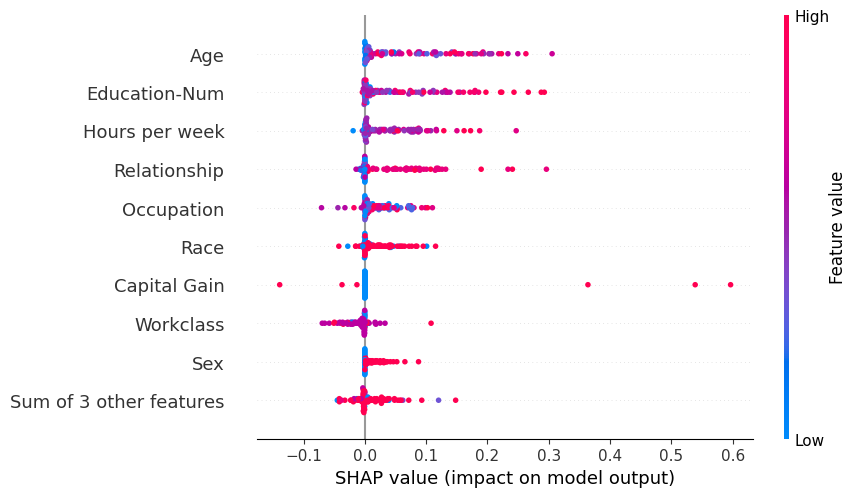

In [ ]:
import xgboost
import shap
import numpy as np
from src.joint_masker import JointMasker

# train XGBoost model
X, y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X.values, y)

# A masking function takes a binary mask vector as the first argument and
# the model arguments for a single sample after that
# It returns a masked version of the input x, where you can return multiple
# rows to average over a distribution of masking types


def custom_masker(mask, x):
    # in this simple example we just zero out the features we are masking
    return (x * mask).reshape(1, len(x))


# compute SHAP values
explainer = shap.Explainer(model.predict_proba, custom_masker)
shap_values = explainer(X[:100])

# plot the SHAP values for the positive class
shap.plots.beeswarm(shap_values[..., 1])

In [ ]:
masker = shap.maskers._text.Text()
